In [1]:
# Import relevant librarie and packages
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
})

In [3]:
# Set some display options for pandas
pd.set_option('display.max_columns', 50)

In [4]:
# Path to the database
DB_PATH = "data/cta_database.db"

In [5]:
# Connect to SQLite database
conn = sqlite3.connect(DB_PATH)

In [6]:
# SQL query to select all data from the table
query = "SELECT * FROM train_positions"

In [7]:
# Load the data into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

In [8]:
# Close the connection
conn.close()

In [9]:
# --- Initial Inspection ---
# Print the shape of the DataFrame
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (38613, 11)


In [10]:
# Print the first 5 rows to see what the data looks like
print("\nFirst 5 rows:")
df.head()


First 5 rows:


,id,fetch_timestamp,run_number,route_name,destination_name,next_station_name,arrival_time,is_delayed,latitude,longitude,heading
0,1,1756299646,801,red,95th/Dan Ryan,Fullerton,1756274472,0,41.93019,-87.65302,177
1,2,1756299646,802,red,95th/Dan Ryan,Lawrence,1756274496,0,41.97345,-87.65853,178
2,3,1756299646,805,red,Howard,Thorndale,1756274499,0,41.99026,-87.65908,357
3,4,1756299646,806,red,Howard,Wilson,1756274607,0,41.95377,-87.65493,271
4,5,1756299646,807,red,Howard,Fullerton,1756274621,0,41.91065,-87.64918,305


In [11]:
# Print a concise summary of the DataFrame
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38613 entries, 0 to 38612
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 38613 non-null  int64  
 1   fetch_timestamp    38613 non-null  int64  
 2   run_number         38613 non-null  object 
 3   route_name         38613 non-null  object 
 4   destination_name   38613 non-null  object 
 5   next_station_name  38613 non-null  object 
 6   arrival_time       38613 non-null  int64  
 7   is_delayed         38613 non-null  int64  
 8   latitude           38613 non-null  float64
 9   longitude          38613 non-null  float64
 10  heading            38613 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 3.2+ MB


In [12]:
# --- Create the GeoDataFrame from our train data ---
# First, drop any rows that might have missing lat/lon data
df_geo = df.dropna(subset=['latitude', 'longitude']).copy()

In [13]:
# Create a 'geometry' column from the latitude and longitude
# This is what makes the DataFrame "map-aware"
geometry = [Point(xy) for xy in zip(df_geo['longitude'], df_geo['latitude'])]
gdf_trains = gpd.GeoDataFrame(df_geo, geometry=geometry, crs="EPSG:4326")

In [14]:
# --- Load the Chicago map shapefile ---
chicago_map = gpd.read_file("geo_data/Boundaries_-_City_20250823.geojson")

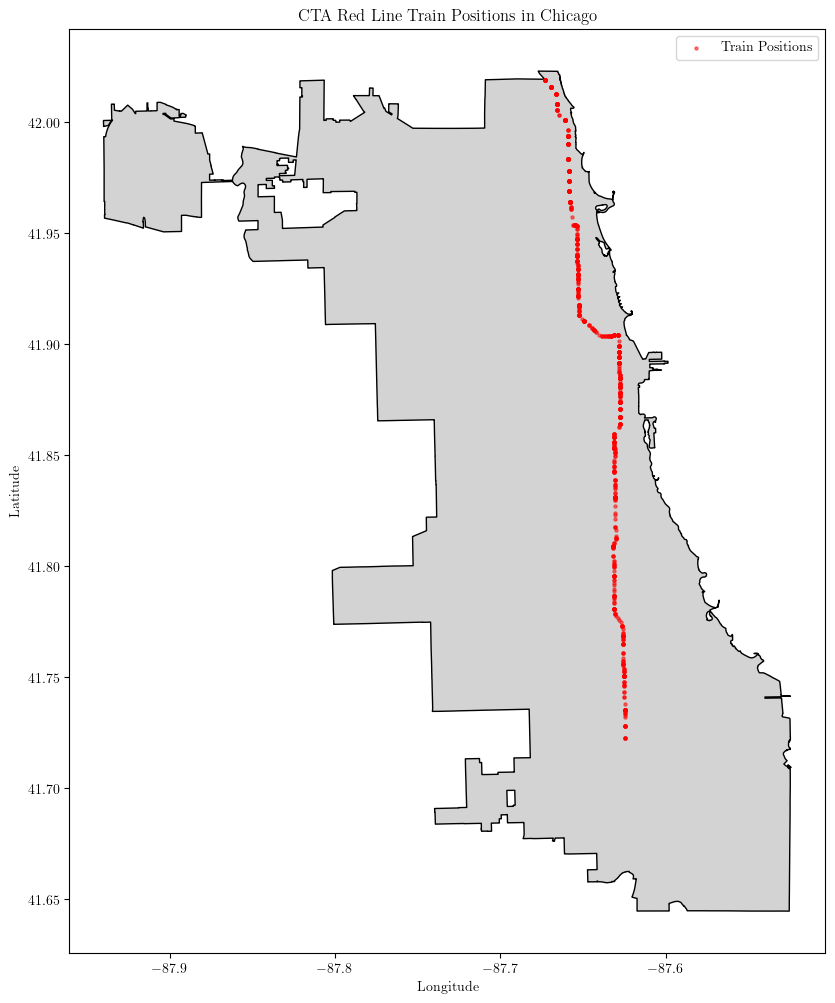

In [15]:
# --- Create the Plot ---
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the map of Chicago as the base layer
chicago_map.plot(ax=ax, color='lightgray', edgecolor='black')

# --- FIX: Adjust the sample size dynamically ---
# Set the sample size to 1000 or the total number of rows, whichever is smaller
sample_size = min(1000, len(gdf_trains))

# Plot the train positions on top using the adjusted sample size
if sample_size > 0:
    gdf_trains.sample(n=sample_size, random_state=42).plot(
        ax=ax, marker='o', color='red', markersize=5, alpha=0.5, label='Train Positions'
    )

# Customize the plot
ax.set_title('CTA Red Line Train Positions in Chicago')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

In [16]:
# Convert Unix timestamps to datetime objects
df['fetch_datetime'] = pd.to_datetime(df['fetch_timestamp'], unit='s')
df['arrival_datetime'] = pd.to_datetime(df['arrival_time'], unit='s')

In [17]:
# Extract useful time features like hour of the day and day of the week
df['hour_of_day'] = df['fetch_datetime'].dt.hour
df['day_of_week'] = df['fetch_datetime'].dt.day_name()

In [18]:
# Display the new columns
display(df[['fetch_datetime', 'arrival_datetime', 'hour_of_day', 'day_of_week']].head())

,fetch_datetime,arrival_datetime,hour_of_day,day_of_week
0,2025-08-27 13:00:46,2025-08-27 06:01:12,13,Wednesday
1,2025-08-27 13:00:46,2025-08-27 06:01:36,13,Wednesday
2,2025-08-27 13:00:46,2025-08-27 06:01:39,13,Wednesday
3,2025-08-27 13:00:46,2025-08-27 06:03:27,13,Wednesday
4,2025-08-27 13:00:46,2025-08-27 06:03:41,13,Wednesday


/var/folders/71/0hnjxlbj1k93ry1fd_9c57200000gn/T/ipykernel_58262/2533354923.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='hour_of_day', palette='viridis')


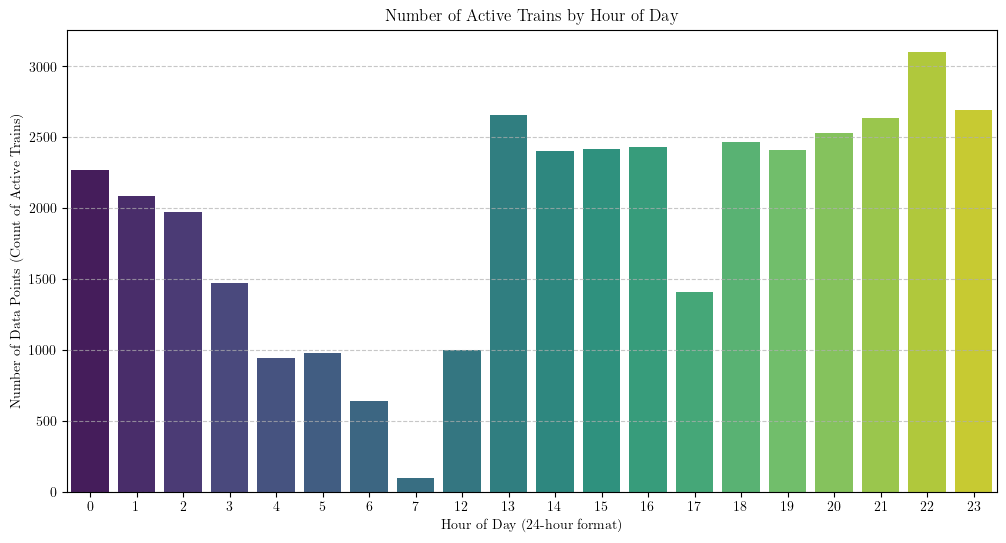

In [19]:
# Plot the number of active trains per hour
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='hour_of_day', palette='viridis')
plt.title('Number of Active Trains by Hour of Day')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Data Points (Count of Active Trains)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculates the distance between two points on Earth in meters."""
    R = 6371000  # Radius of Earth in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

In [21]:
# Sort the data so consecutive readings for each train are next to each other
df_sorted = df.sort_values(by=['run_number', 'fetch_timestamp']).copy()

In [22]:
# Group by train and calculate the change in time and position
df_sorted['time_diff_s'] = df_sorted.groupby('run_number')['fetch_timestamp'].diff()
df_sorted['lat_prev'] = df_sorted.groupby('run_number')['latitude'].shift(1)
df_sorted['lon_prev'] = df_sorted.groupby('run_number')['longitude'].shift(1)

In [23]:
# Calculate the distance traveled between readings
df_sorted['distance_m'] = haversine_distance(
    df_sorted['lat_prev'], df_sorted['lon_prev'],
    df_sorted['latitude'], df_sorted['longitude']
)

In [24]:
# Calculate speed in meters per second (and handle cases where time_diff is zero)
df_sorted['speed_mps'] = (df_sorted['distance_m'] / df_sorted['time_diff_s']).fillna(0)

In [25]:
# Convert to a more intuitive unit like kilometers per hour
df_sorted['speed_kmh'] = df_sorted['speed_mps'] * 3.6

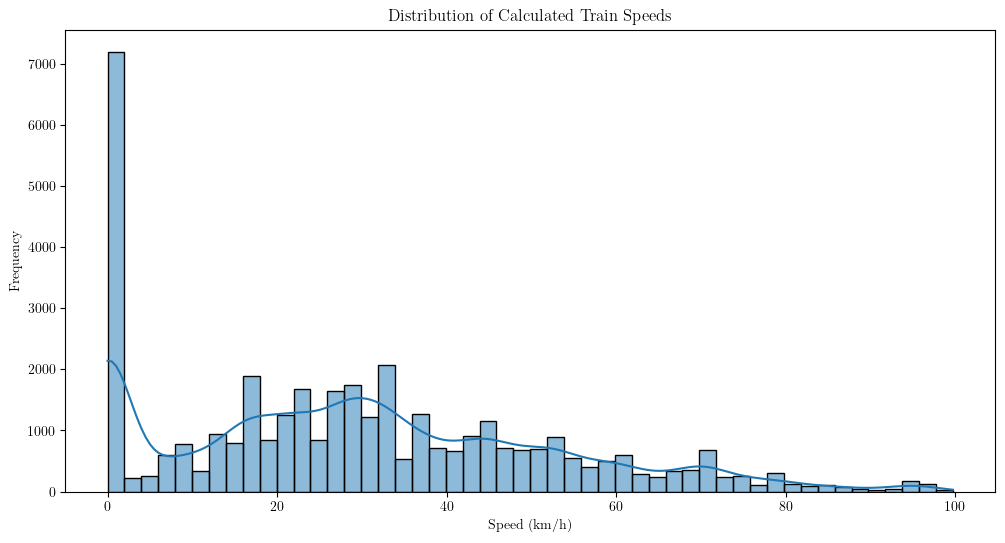

In [26]:
# --- Visualize Speed Distribution ---
plt.figure(figsize=(12, 6))
# We'll filter out speeds over 100 km/h as they are likely errors from GPS jumps
sns.histplot(df_sorted[df_sorted['speed_kmh'] < 100]['speed_kmh'], bins=50, kde=True)
plt.title('Distribution of Calculated Train Speeds')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Calculate the percentage of readings that are flagged as delayed
delay_percentage = df['is_delayed'].value_counts(normalize=True) * 100
print(f"Percentage of delayed readings:\n{delay_percentage}\n")

Percentage of delayed readings:
is_delayed
0    98.43835
1     1.56165
Name: proportion, dtype: float64



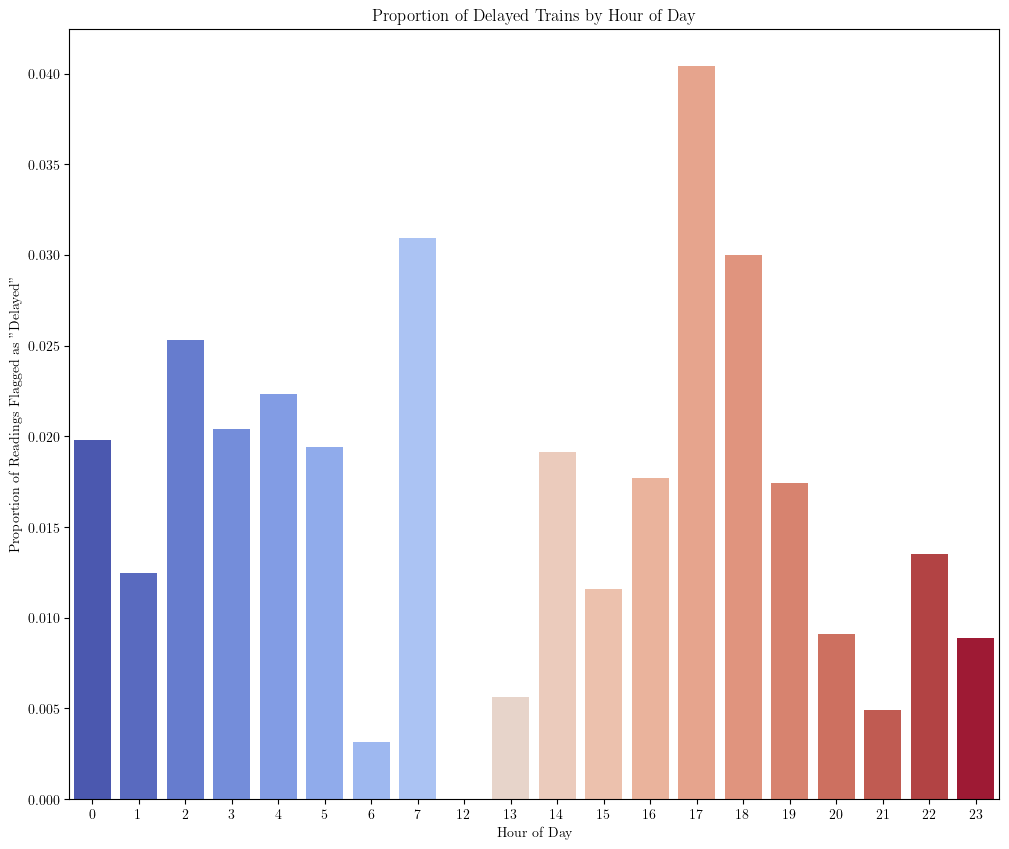

In [28]:
# Visualize delays by hour of the day (updated code)
plt.figure(figsize=(12, 10))

# Use errorbar=None instead of ci=None
# Assign 'hour_of_day' to hue to maintain the color palette
sns.barplot(
    data=df, 
    x='hour_of_day', 
    y='is_delayed', 
    errorbar=None,  # Updated parameter
    palette='coolwarm',
    hue='hour_of_day', # Added to maintain color mapping
    legend=False     # Added to hide the unnecessary legend
)

plt.title('Proportion of Delayed Trains by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion of Readings Flagged as "Delayed"')
plt.show()

In [29]:
# Assign the feature-engineered dataframe back to your main df
df = df_sorted

In [30]:
# Filter out speeds that are likely errors or when the train is stopped
df_speed = df[(df['speed_kmh'] > 1) & (df['speed_kmh'] < 100)].copy()

In [31]:
# Calculate the mean and standard deviation of speed for each hour of the day
hourly_stats = df_speed.groupby('hour_of_day')['speed_kmh'].agg(['mean', 'std']).reset_index()
hourly_stats.rename(columns={'mean': 'hourly_mean_speed', 'std': 'hourly_std_speed'}, inplace=True)

In [32]:
# Merge these hourly stats back into our main dataframe
df_speed = pd.merge(df_speed, hourly_stats, on='hour_of_day', how='left')

In [33]:
# Calculate the Z-score for each data point
df_speed['speed_zscore'] = (df_speed['speed_kmh'] - df_speed['hourly_mean_speed']) / df_speed['hourly_std_speed']

In [34]:
# --- Identify and Display Anomalies ---
z_score_threshold = 3
df_speed['is_anomaly'] = df_speed['speed_zscore'].abs() > z_score_threshold

anomalies = df_speed[df_speed['is_anomaly']]

print(f"\nFound {len(anomalies)} potential point anomalies (Z-score > {z_score_threshold}).")


Found 126 potential point anomalies (Z-score > 3).


In [35]:
# Display the top 10 most anomalous readings
print("\nTop 10 Anomalous Readings:")
display(anomalies.sort_values(by='speed_zscore', ascending=False).head(10))


Top 10 Anomalous Readings:


,id,fetch_timestamp,run_number,route_name,destination_name,next_station_name,arrival_time,is_delayed,latitude,longitude,heading,fetch_datetime,arrival_datetime,hour_of_day,day_of_week,time_diff_s,lat_prev,lon_prev,distance_m,speed_mps,speed_kmh,hourly_mean_speed,hourly_std_speed,speed_zscore,is_anomaly
17833,20368,1756480709,908,red,Howard,Jackson,1756455534,0,41.87404,-87.62748,0,2025-08-29 15:18:29,2025-08-29 08:18:54,15,Friday,60.0,41.85943,-87.63138,1656.346181,27.605770,99.380771,33.772656,18.899883,3.471350,True
176,3556,1756309650,801,red,95th/Dan Ryan,North/Clybourn,1756284556,0,41.91065,-87.64918,125,2025-08-27 15:47:30,2025-08-27 08:49:16,15,Wednesday,60.0,41.92505,-87.65287,1630.055039,27.167584,97.803302,33.772656,18.899883,3.387886,True
3858,18695,1756394045,811,red,95th/Dan Ryan,69th,1756368960,0,41.78054,-87.63100,178,2025-08-28 15:14:05,2025-08-28 08:16:00,15,Thursday,61.0,41.79542,-87.63117,1654.640539,27.125255,97.650917,33.772656,18.899883,3.379823,True
4775,21142,1756483148,815,red,95th/Dan Ryan,Cermak-Chinatown,1756458038,0,41.85323,-87.63098,191,2025-08-29 15:59:08,2025-08-29 09:00:38,15,Friday,60.0,41.86740,-87.62740,1603.282804,26.721380,96.196968,33.772656,18.899883,3.302894,True
20085,2090,1756305165,914,red,95th/Dan Ryan,Fullerton,1756280070,0,41.93225,-87.65310,176,2025-08-27 14:32:45,2025-08-27 07:34:30,14,Wednesday,61.0,41.94743,-87.65363,1688.508139,27.680461,99.649661,36.337775,19.636043,3.224269,True
3406,2800,1756307348,810,red,95th/Dan Ryan,Cermak-Chinatown,1756282258,0,41.85323,-87.63098,191,2025-08-27 15:09:08,2025-08-27 08:10:58,15,Wednesday,61.0,41.86740,-87.62740,1603.282804,26.283325,94.619969,33.772656,18.899883,3.219454,True
20747,20457,1756480952,915,red,95th/Dan Ryan,Cermak-Chinatown,1756455852,0,41.85323,-87.63098,163,2025-08-29 15:22:32,2025-08-29 08:24:12,15,Friday,61.0,41.86740,-87.62740,1603.282804,26.283325,94.619969,33.772656,18.899883,3.219454,True
20494,3202,1756308560,915,red,95th/Dan Ryan,Cermak-Chinatown,1756283452,0,41.85323,-87.63098,191,2025-08-27 15:29:20,2025-08-27 08:30:52,15,Wednesday,61.0,41.86740,-87.62740,1603.282804,26.283325,94.619969,33.772656,18.899883,3.219454,True
4241,3761,1756310197,814,red,95th/Dan Ryan,Cermak-Chinatown,1756285091,0,41.85323,-87.63098,163,2025-08-27 15:56:37,2025-08-27 08:58:11,15,Wednesday,61.0,41.86740,-87.62740,1603.282804,26.283325,94.619969,33.772656,18.899883,3.219454,True
3659,2881,1756307590,811,red,95th/Dan Ryan,Cermak-Chinatown,1756282497,0,41.85323,-87.63098,163,2025-08-27 15:13:10,2025-08-27 08:14:57,15,Wednesday,61.0,41.86740,-87.62740,1603.282804,26.283325,94.619969,33.772656,18.899883,3.219454,True
